In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U \
  "trl==0.19.0" \
  "datasets>=3.6.0" \
  "transformers>=4.42.0" \
  "accelerate>=0.29.0" \
  "fsspec==2025.3.0" \
  "gcsfs==2025.3.0" \
  "bitsandbytes==0.46.0" \
  "peft"

In [ ]:
import warnings

# 경고 메시지 패턴을 필터링
warnings.filterwarnings(
    "ignore",
    message=r".*torch.utils.checkpoint: the use_reentrant parameter.*",
    category=UserWarning
)

In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

# -------------------------------------------------
# 1. 데이터 로딩 및 프롬프트 분리
# -------------------------------------------------

# CSV에서 원본 데이터 로딩
df_sft = pd.read_csv("/content/drive/MyDrive/jeju_ppodpo/data/df_sft.csv")
df_dpo = pd.read_csv("/content/drive/MyDrive/jeju_ppodpo/data/df_dpo.csv")

# df_dpo에서 일부 샘플만 사용하고 rejected 제거
df_dpo_15000 = df_dpo.head(15000).drop(columns=["rejected"])
df_sft = pd.concat([df_sft, df_dpo_15000])
df_sft = df_sft[df_sft["dialect"].fillna("").astype(str).str.len() < 150].reset_index(drop=True)

# 프롬프트 및 정답 분리
def build_prompt(example):
    prompt = f"""<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
다음 제주 방언 문장을 표준어로 번역.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{example["dialect"]}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>\n"""
    return {
        "prompt": prompt,
        "completion": example["standard"] + "<|eot_id|>",
    }

# Dataset 생성 및 분할
dataset_prompted = Dataset.from_pandas(df_sft).map(build_prompt)
dataset_prompted = dataset_prompted.train_test_split(test_size=0.05)

# -------------------------------------------------
# 2. 토크나이저 및 모델 로드
# -------------------------------------------------
model_id = "Bllossom/llama-3.2-Korean-Bllossom-3B"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

# -------------------------------------------------
# 3. 정밀한 토크나이징 (loss 계산 부분만 labels)
# -------------------------------------------------
def tokenize(example):
    prompt_ids = tokenizer(
        example["prompt"],
        add_special_tokens=False
    )["input_ids"]

    completion_ids = tokenizer(
        example["completion"],
        add_special_tokens=False
    )["input_ids"]

    input_ids = prompt_ids + completion_ids
    labels = [-100] * len(prompt_ids) + completion_ids
    attention_mask = [1] * len(input_ids)

    # 가장 긴 길이에 맞춰 padding
    max_length = 256  # 또는 원하는 길이

    pad_token_id = tokenizer.pad_token_id
    input_ids = input_ids[:max_length] + [pad_token_id] * max(0, max_length - len(input_ids))
    attention_mask = attention_mask[:max_length] + [0] * max(0, max_length - len(attention_mask))
    labels = labels[:max_length] + [-100] * max(0, max_length - len(labels))

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }



tokenized_ds = dataset_prompted.map(
    tokenize,
    remove_columns=dataset_prompted["train"].column_names,
)
tokenized_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
from transformers import TrainerCallback, EarlyStoppingCallback

# -------------------------------------------------
# 4. 학습 설정 및 Trainer
# -------------------------------------------------
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/jeju_ppodpo/jeju_sft_temp",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=600,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    seed=42,
    report_to="tensorboard",
)

from transformers import TrainerCallback

class EvalPredictionPrinterCallback(TrainerCallback):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def on_evaluate(self, args, state, control, model=None, eval_dataloader=None, **kwargs):
        tokenizer = self.tokenizer

        print(f"\n [Evaluation @ Step {state.global_step}] ===============================")

        sample_ds = next(iter(eval_dataloader))
        input_ids_batch = sample_ds["input_ids"][:5]
        labels_batch = sample_ds["labels"][:5]

        #  정답이 시작되기 전까지 자름
        def extract_prompt_only(input_ids, labels):
            for i, label in enumerate(labels):
                if label != -100:
                    return input_ids[:i]
            return input_ids

        prompt_ids_list = [
            extract_prompt_only(input_ids.tolist(), labels.tolist())
            for input_ids, labels in zip(input_ids_batch, labels_batch)
        ]

        prompt_batch = tokenizer.pad(
            {"input_ids": prompt_ids_list},
            padding=True,
            return_tensors="pt"
        ).to(model.device)

        outputs = model.generate(
            input_ids=prompt_batch["input_ids"],
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        decoded_prompts = tokenizer.batch_decode(prompt_batch["input_ids"], skip_special_tokens=True)

        def clean_label(label_ids):
            return [tok for tok in label_ids if tok != -100]

        decoded_labels = tokenizer.batch_decode(
            [clean_label(lbl.tolist()) for lbl in labels_batch],
            skip_special_tokens=True
        )
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        for i in range(len(decoded_preds)):
            print(f"\n Prompt {i+1}:\n{decoded_prompts[i]}")
            print(f"\n 정답:\n\n{decoded_labels[i]}")
            print(f"\n 모델:\n{decoded_preds[i]}")
            print("\n" + "=" * 60)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    callbacks=[
        EvalPredictionPrinterCallback(tokenizer),
        EarlyStoppingCallback(early_stopping_patience=3),
    ],
)


# -------------------------------------------------
# 5. 학습 시작
# -------------------------------------------------
trainer.train()


/tmp/ipython-input-25-3979034866.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
200,0.832300,0.790465
400,0.673700,0.650192
600,0.572900,0.545803
800,0.498300,0.471736
1000,0.440100,0.425283
1200,0.384100,0.391708
1400,0.374600,0.368689
1600,0.341400,0.352886
1800,0.331600,0.337915
2000,0.316700,0.329686


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 200] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant

여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살아수다


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 400] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant

여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살아수다


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 600] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant

여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔았어요 신제주로 오전했으니 일로 왔습니다요 했더니 저 구제주에 용담동에 살다가 신제주들 아주 공동주택 지어난 일로 완마씨 이제까지 살았어요


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 800] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant  여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔았어요 신제주로 오전했으니 일로 왔습니다했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어난 일로 완마씨 이제까지 살았습니다


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 1000] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant  여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔았어요 신제주로 오젠헤니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어난 일로 완마씨 이제까지 살았습니다


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 1200] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant  여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔았어요 신제주로 오젠헤난 일로 왔습니다요 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살았습니다


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 1400] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant  여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔았어요 신제주로 오전해서 일로 왔습니다요 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어난 일로 완마씨 이제까지 살았습니다


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 1600] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant



 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방 청소 다 허민 뒷무뚱도 쓸라
assistant


 정답:

마루 청소 다 하면 뒷문 뒤도 쓸어라

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 1800] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant  여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살았습니다


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 2000] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant
assistant  여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔았어요 신제주로 오젠헤니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가니까 일로 완마씨 이제까지 살았습니다


 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 2200] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant



 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방 청소 다 허민 뒷무뚱도 쓸라
assistant


 정답:

마루 청소 다 하면 뒷문 뒤도 쓸어라

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 2400] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant



 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방 청소 다 허민 뒷무뚱도 쓸라
assistant


 정답:

마루 청소 다 하면 뒷문 뒤도 쓸어라

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 2600] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant



 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방 청소 다 허민 뒷무뚱도 쓸라
assistant


 정답:

마루 청소 다 하면 뒷문 뒤도 쓸어라

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 2800] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant



 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방 청소 다 허민 뒷무뚱도 쓸라
assistant


 정답:

마루 청소 다 하면 뒷문 뒤도 쓸어라

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



 [Evaluation @ Step 3000] ===============================

 Prompt 1:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant


 정답:

오늘 누구 손님 오니

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
오늘 누게 손님 올 거라
assistant



 Prompt 2:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant


 정답:

여기로 온 거 아니 저 옛집 저기 그냥 주택 팔아서요 신제주로 오려고하니까 일로 왔습니다 했더니 저 구제주에 용담동에 살다가 신제주들 막 공동주택 지어가난 일로 왔어요 이제까지 살고있어요

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
여기로 온 거 아니 저 묵은집 저기 그냥 주택 팔아둰예 신제주로 오젠헤난 일로 왓수다게 했더니 저 구제주에 용담동에 살단에 신제주들 막 공동주택 지어가난 일로 완마씨 이제까지 살암수다
assistant



 Prompt 3:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant


 정답:

갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant



 Prompt 4:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방 청소 다 허민 뒷무뚱도 쓸라
assistant


 정답:

마루 청소 다 하면 뒷문 뒤도 쓸어라

 모델:

system
다음 제주 방언 문장을 표준어로 번역.
user
상방

TrainOutput(global_step=3015, training_loss=0.4141433707912565, metrics={'train_runtime': 6805.2154, 'train_samples_per_second': 14.175, 'train_steps_per_second': 0.443, 'total_flos': 4.1798134518408806e+17, 'train_loss': 0.4141433707912565, 'epoch': 3.0})

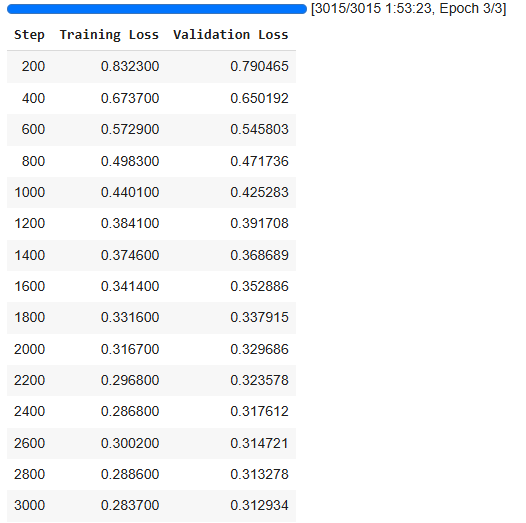

In [ ]:
# LoRA 모델 저장
model.save_pretrained("/content/drive/MyDrive/jeju_ppodpo/jeju_sft")
tokenizer.save_pretrained("/content/drive/MyDrive/jeju_ppodpo/jeju_sft")


('/content/drive/MyDrive/jeju_ppodpo/jeju_sft/tokenizer_config.json',
 '/content/drive/MyDrive/jeju_ppodpo/jeju_sft/special_tokens_map.json',
 '/content/drive/MyDrive/jeju_ppodpo/jeju_sft/chat_template.jinja',
 '/content/drive/MyDrive/jeju_ppodpo/jeju_sft/tokenizer.json')

before

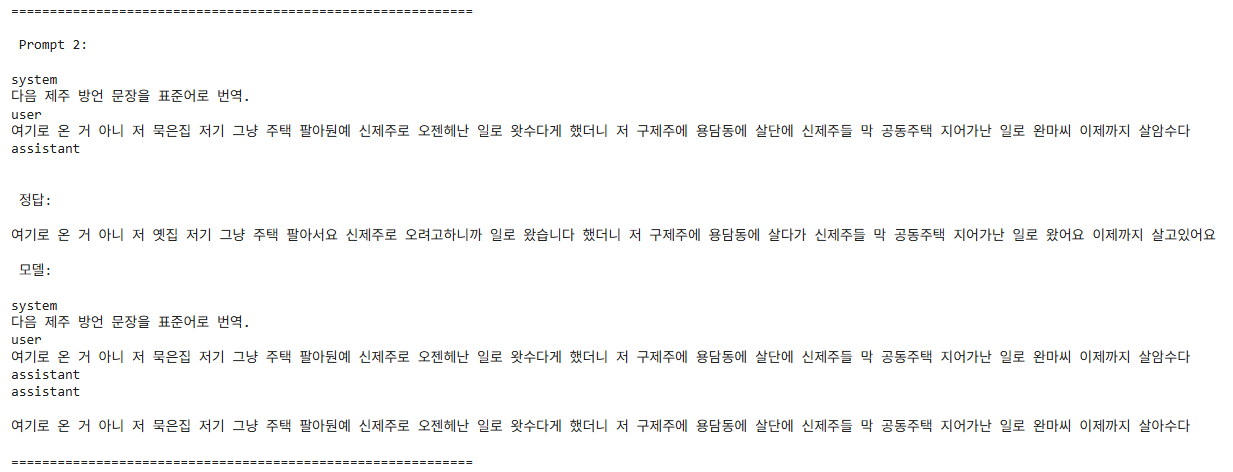

after

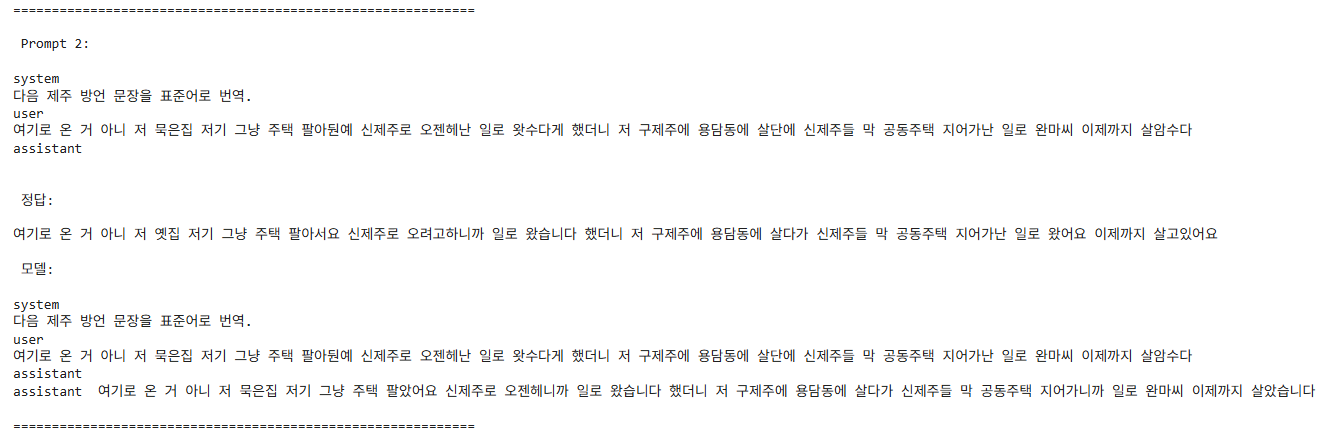

before

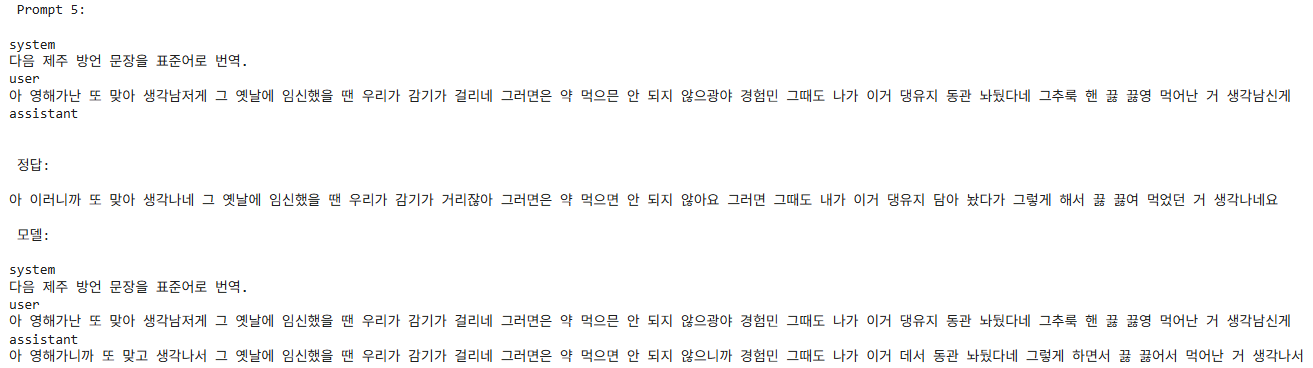

after

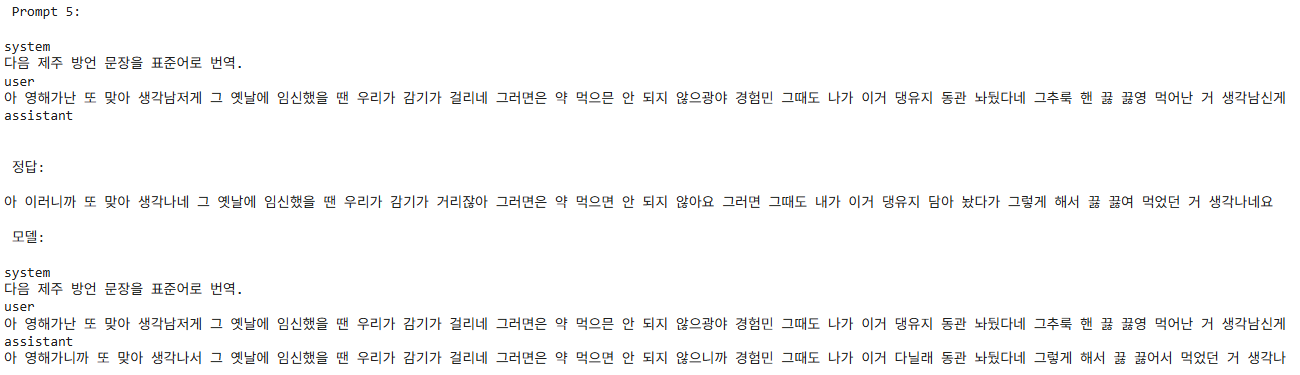

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig

# -------------------------------------------------
# 1. 저장된 모델 경로
# -------------------------------------------------
model_dir = "/content/drive/MyDrive/jeju_ppodpo/jeju_sft"

# -------------------------------------------------
# 2. 토크나이저 및 모델 로드
# -------------------------------------------------
# LoRA 어댑터 구성 불러오기
peft_config1 = PeftConfig.from_pretrained(model_dir)

# Base 모델 로드
base_model1 = AutoModelForCausalLM.from_pretrained(
    peft_config1.base_model_name_or_path,
    device_map="auto",
    torch_dtype=torch.bfloat16,     # 또는 학습 때 사용한 torch.float16
    load_in_4bit=True
)

# LoRA 모델 로드
model1 = PeftModel.from_pretrained(base_model1, model_dir)
model1.eval()

# 토크나이저 로드
tokenizer1 = AutoTokenizer.from_pretrained(model_dir, use_fast=False)
tokenizer1.pad_token = tokenizer1.eos_token  # LLaMA 계열은 eos = pad

# -------------------------------------------------
# 3. 번역 프롬프트 생성 함수
# -------------------------------------------------
def build_prompt(dialect_text):
    return f"""<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
다음 제주 방언 문장을 표준어로 번역.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{dialect_text}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

# -------------------------------------------------
# 4. 번역 실행 함수
# -------------------------------------------------
def translate_jeju(dialect_text, max_new_tokens=128):
    prompt = build_prompt(dialect_text)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # greedy decoding
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text.replace(prompt.strip(), "").strip()

# -------------------------------------------------
# 5. 테스트 실행
# -------------------------------------------------
jeju_sentence1 = "갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주"
translation1 = translate_jeju(jeju_sentence1)

print("\n\n\n 번역 결과:")
print("\n제주 방언:", jeju_sentence1)
print("\n표준어 정답: 갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지")
print("\n=================================================================")
print("\n표준어 번역:", translation1)

jeju_sentence2 = "아 영해가난 또 맞아 생각남저게 그 옛날에 임신했을 땐 우리가 감기가 걸리네 그러면은 약 먹으믄 안 되지 않으광야 경험민 그때도 나가 이거 댕유지 동관 놔뒀다네 그추룩 핸 끓 끓영 먹어난 거 생각남신게"
translation2 = translate_jeju(jeju_sentence2)

print("\n\n\n 번역 결과:")
print("\n제주 방언:", jeju_sentence2)
print("\n표준어 정답: 아 이러니까 또 맞아 생각나네 그 옛날에 임신했을 땐 우리가 감기가 거리잖아 그러면은 약 먹으면 안 되지 않아요 그러면 그때도 내가 이거 댕유지 담아 놨다가 그렇게 해서 끓 끓여 먹었던 거 생각나네요")
print("\n=================================================================")
print("\n표준어 번역:", translation2)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.





 번역 결과:

제주 방언: 갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주

표준어 정답: 갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지


표준어 번역: system
다음 제주 방언 문장을 표준어로 번역.
user
갯것이 강 구젱기영 메역이영 헹 와사 먹을 게 싯주
assistant
갯가에 가서 소라랑 미역이랑 해서 와야 먹을 게 있지



 번역 결과:

제주 방언: 아 영해가난 또 맞아 생각남저게 그 옛날에 임신했을 땐 우리가 감기가 걸리네 그러면은 약 먹으믄 안 되지 않으광야 경험민 그때도 나가 이거 댕유지 동관 놔뒀다네 그추룩 핸 끓 끓영 먹어난 거 생각남신게

표준어 정답: 아 이러니까 또 맞아 생각나네 그 옛날에 임신했을 땐 우리가 감기가 거리잖아 그러면은 약 먹으면 안 되지 않아요 그러면 그때도 내가 이거 댕유지 담아 놨다가 그렇게 해서 끓 끓여 먹었던 거 생각나네요


표준어 번역: system
다음 제주 방언 문장을 표준어로 번역.
user
아 영해가난 또 맞아 생각남저게 그 옛날에 임신했을 땐 우리가 감기가 걸리네 그러면은 약 먹으믄 안 되지 않으광야 경험민 그때도 나가 이거 댕유지 동관 놔뒀다네 그추룩 핸 끓 끓영 먹어난 거 생각남신게
assistant
아 이렇게 해서 또 맞았었어 그 옛날에 임신했을 땐 우리가 감기가 걸리네 그러면은 약 먹으면 안 되니까 경험민 그때도 나가 이거 다닌다서 동관 놔뒀다니깐 핸 끓 끓어서 먹었던 거 생각나


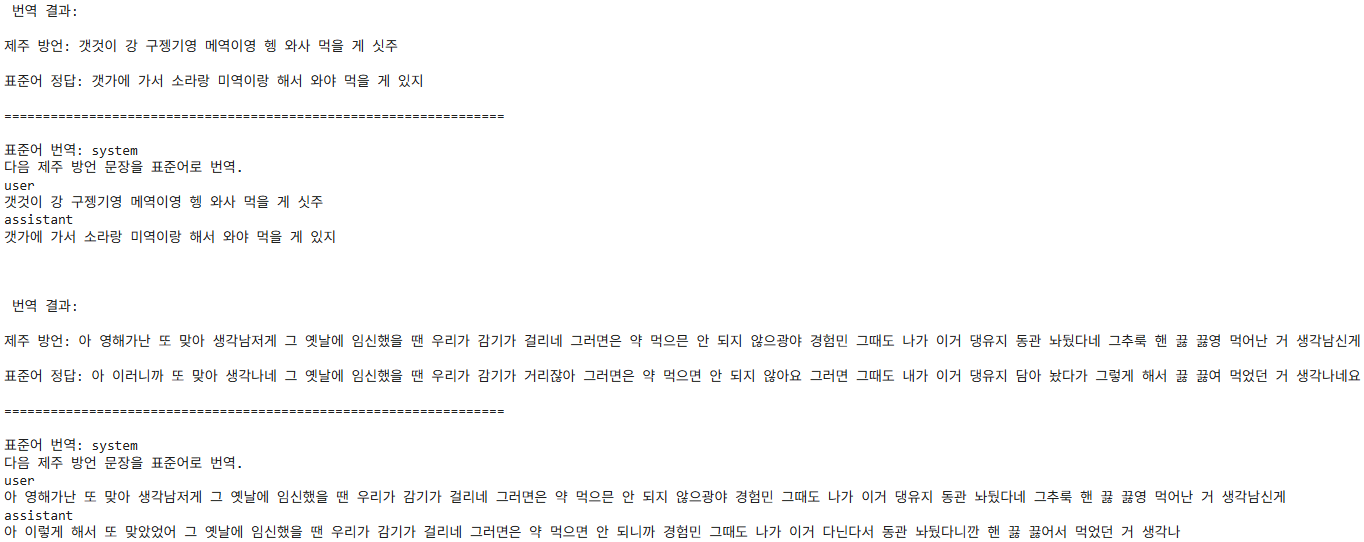

In [ ]:
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
from tqdm import tqdm

# 평가용 테스트셋 불러오기
df_test = pd.read_csv("/content/drive/MyDrive/jeju_ppodpo/data/df_test.csv")
df_test = df_test.head(1000)

# 프롬프트 구성 함수 재사용
def make_prompt(dialect):
    return f"""<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
다음 제주 방언 문장을 표준어로 번역.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{dialect}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

# BLEU 계산용 함수
def compute_bleu_scores(preds, refs):
    smoothie = SmoothingFunction().method4
    scores = [
        sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie)
        for pred, ref in zip(preds, refs)
    ]
    return np.mean(scores)

# 모델을 평가 모드로 전환
model.eval()

# 예측 수행
predictions = []
references = df_test["standard"].tolist()

for dialect in tqdm(df_test["dialect"].tolist(), desc="Evaluating"):
    prompt = make_prompt(dialect)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # 프롬프트 부분 잘라내기 (assistant 다음부터)
    if "<|start_header_id|>assistant<|end_header_id|>" in prompt:
        pred = pred.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
    predictions.append(pred)

# BLEU 계산
bleu_score = compute_bleu_scores(predictions, references)
print(f"\n BLEU Score: {bleu_score:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Evaluating: 100%|██████████| 1000/1000 [29:51<00:00,  1.79s/it]


 BLEU Score: 0.1984


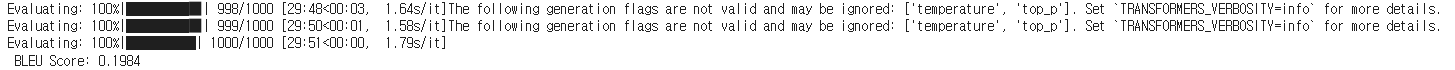